# Extracting frames for interpreting the policy projection plots

Note: video/image manipulation requires OpenCV, which isn't included in the conda environment setup for the rest of this project (out of fear of breaking other dependencies). To run this notebook, I suggest using a separate conda environment that has OpenCV installed (since we're just processing videos/images, the new conda environment doesn't need to have all the packages that `rl_vcf` has).

This can be done by following this guide: https://saturncloud.io/blog/installing-opencv-with-conda-a-guide-for-data-scientists/ (but use Python 3.10 instead).

Remember to also install the `ipykernel` and `matplotlib` packages for the new environment! `conda install ipykernel matplotlib`

In [10]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from collections.abc import Container
import pickle

In [14]:
def extract_frames(
    ep_idxs: Container[int],
    alpha: float | None = None,
    datetime: str | None = None,
    crop_lims: tuple | None = None,
) -> list:
    """
    Extract frames from each episode video.
    """
    frames = []

    if (alpha is None and datetime is None) or (
        alpha is not None and datetime is not None
    ):
        raise ValueError("You must provide either an alpha or a datetime.")

    for ep_idx in ep_idxs:
        ep_frames = []
        if datetime is not None:
            cam = cv2.VideoCapture(
                "../../src/rl_vcf/outputs/"
                + datetime
                + "/videos/rl-video-episode-{ep_idx}.mp4".format(ep_idx=ep_idx)
            )
        elif alpha is not None:
            alpha_str = str(float(alpha)).replace(".", "-")
            cam = cv2.VideoCapture(
                "../../src/rl_vcf/videos/videos_alpha_"
                + alpha_str
                + "/rl-video-episode-{ep_idx}.mp4".format(ep_idx=ep_idx)
            )
        while True:
            ret, frame = cam.read()
            if not ret:
                break
            if crop_lims is not None:
                frame = frame[crop_lims[0] : crop_lims[1], crop_lims[2] : crop_lims[3]]
            frame = cv2.cvtColor(frame.astype(np.uint8), cv2.COLOR_BGR2RGB)
            frame = frame.tolist()
            ep_frames.append(frame)

        # For some reason, each video for ep_idx > 0 has 1 extra frame at the start from the end of the previous episode
        if ep_idx > 0:
            ep_frames = ep_frames[1:]

        frames.append(ep_frames)

    cam.release()

    return frames

In [24]:
# Extract frames
frames = extract_frames(
    alpha=5.0,
    ep_idxs=np.arange(0, 1000, 100),
    crop_lims=(0, 200, 0, 200),
)
filename = "extracted_frames.pkl"
with open(filename, "wb") as file:
    pickle.dump(frames, file, pickle.HIGHEST_PROTOCOL)

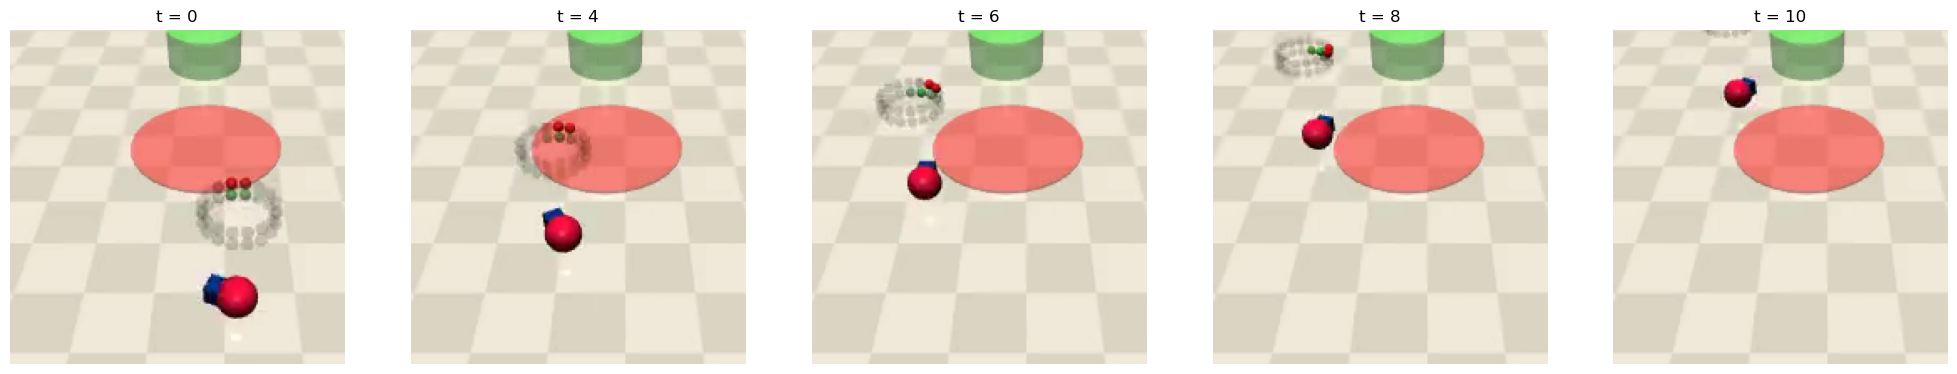

In [25]:
timesteps_to_plot = [0, 4, 6, 8, 10]
fig, axs = plt.subplots(
    1,
    len(timesteps_to_plot),
    figsize=(len(timesteps_to_plot) * 5, 5),
)
for k, idx in enumerate(timesteps_to_plot):
    axs[k].imshow(frames[1][idx])
    axs[k].set_title(f"t = {idx}")
    axs[k].axis("off")
plt.show()